In [1]:
import os
import zipfile
import glob
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
#1️ Extract ZIP Files

image_zip = "RoadSeg2.v3i.700img_Original.zip"
label_zip = "RoadSeg2.v3i.700img_Masks.zip"

image_extract_dir = os.path.splitext(image_zip)[0]  
label_extract_dir = os.path.splitext(label_zip)[0]   

os.makedirs(image_extract_dir, exist_ok=True)
os.makedirs(label_extract_dir, exist_ok=True)

# Extract image zip
with zipfile.ZipFile(image_zip, "r") as z:
    z.extractall(image_extract_dir)

# Extract mask zip
with zipfile.ZipFile(label_zip, "r") as z:
    z.extractall(label_extract_dir)

print("Extraction complete!")

#2️ Dataset Paths
image_base = os.path.join(image_extract_dir, "images")
label_base = os.path.join(label_extract_dir, "masks_class3_white")

print("Image base:", image_base)
print("Label base:", label_base)

#3️ Helper Functions

IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 60

def load_image_mask(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask, tf.float32) / 255.0  # Normalize mask too

    return img, mask

def augment_image_mask(img, mask):
    # Data augmentation
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_brightness(img, max_delta=0.2)
    return img, mask

def create_dataset(image_dir, mask_dir, augment=False):
    image_paths = sorted(glob.glob(os.path.join(image_dir, "**/*.jpg"), recursive=True))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "**/*.png"), recursive=True))

    print(f"Found {len(image_paths)} images and {len(mask_paths)} masks in {image_dir}")

    if len(image_paths) == 0 or len(mask_paths) == 0:
        print("No images or masks found. Check folder structure!")

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(augment_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.shuffle(256).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset


#4️ Create Datasets

train_ds = create_dataset(
    os.path.join(image_base, "train"), 
    os.path.join(label_base, "train"), augment=True)

val_ds = create_dataset(
    os.path.join(image_base, "valid"),
    os.path.join(label_base, "valid")
)

#5 Define Simple U-N

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)
    return models.Model(inputs, outputs)

def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / (union + 1e-7)
    return iou

model = unet_model()
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', iou_metric])
model.summary()

#6 Train Model

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
model.save("road_segmentation_unet700img.keras")

Extraction complete!
Image base: RoadSeg2.v3i.700img_Original\images
Label base: RoadSeg2.v3i.700img_Masks\masks_class3_white
Found 549 images and 549 masks in RoadSeg2.v3i.700img_Original\images\train
Found 115 images and 115 masks in RoadSeg2.v3i.700img_Original\images\valid


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 256, 256,  │      2,320 │ conv2d_9[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_11[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_13[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 128, 128,  │          0 │ conv2d_14[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 96)               │            │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │     27,680 │ concatenate_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 256, 256,  │          0 │ conv2d_15[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256, 256,  │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 48)               │            │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │      6,928 │ concatenate_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 256, 256,  │         17 │ conv2d_16[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 106,705 (416.82 KB)

 Trainable params: 106,705 (416.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 419ms/step - accuracy: 0.8558 - iou_metric: 0.0051 - loss: 0.4015 - val_accuracy: 0.8693 - val_iou_metric: 0.0000e+00 - val_loss: 0.2892
Epoch 2/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 426ms/step - accuracy: 0.8925 - iou_metric: 0.0195 - loss: 0.2248 - val_accuracy: 0.8715 - val_iou_metric: 0.0180 - val_loss: 0.2741
Epoch 3/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 428ms/step - accuracy: 0.9250 - iou_metric: 0.4365 - loss: 0.1688 - val_accuracy: 0.8937 - val_iou_metric: 0.2100 - val_loss: 0.2431
Epoch 4/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - accuracy: 0.9272 - iou_metric: 0.4517 - loss: 0.1681 - val_accuracy: 0.8736 - val_iou_metric: 0.0350 - val_loss: 0.2656
Epoch 5/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 447ms/step - accuracy: 0.9375 - iou_metric: 0.5090 - loss: 0.1488 - val_accuracy: 0.9001 - val_iou_metric: 0.2506 - val_loss: 0.2393
Epoch 6/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 449ms/step - accuracy: 0.9376 - iou_metric: 0.5174 - loss: 0.1456 - val_accurac

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


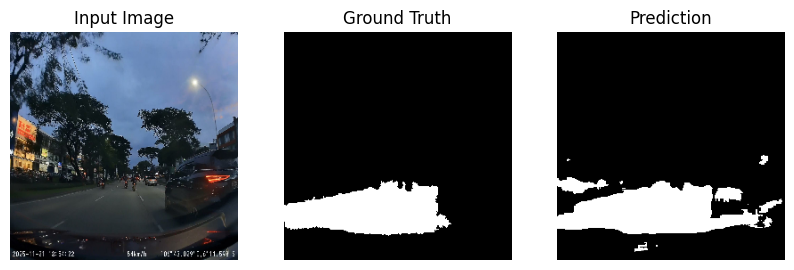

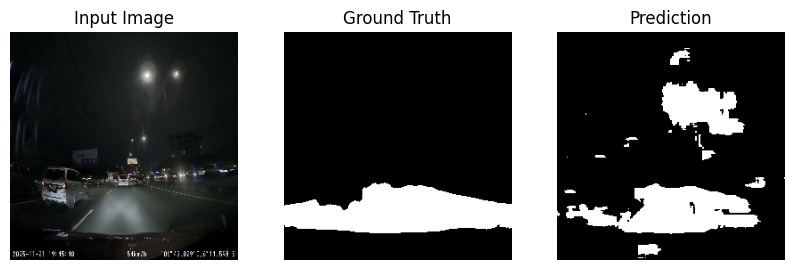

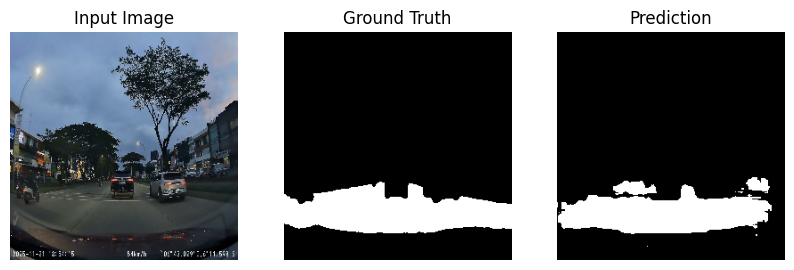

In [5]:
#7 Visualize Predictions

def display_predictions(dataset, model, num=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        for i in range(num):
            plt.figure(figsize=(10, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(tf.squeeze(masks[i]), cmap='gray')
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(tf.squeeze(preds[i] > 0.5), cmap='gray')
            plt.title("Prediction")
            plt.axis("off")
            plt.show()

display_predictions(val_ds, model)